# MV Optimization of the Harvard Endowment

## HBS Case

### *The Harvard Management Company and Inflation-Indexed Bonds*

***

# Setup

## Data

In [1]:
import numpy as np
import pandas as pd
pd.options.display.float_format = "{:,.4f}".format

import warnings
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

In [2]:
filepath_data = '../data/multi_asset_etf_data.xlsx'
info = pd.read_excel(filepath_data,sheet_name='descriptions')
info.set_index('ticker',inplace=True)

rets = pd.read_excel(filepath_data,sheet_name='total returns')
rets.set_index('Date',inplace=True)

Sort columns by order of descriptions in Info tab

In [3]:
symbol_list = info.index
rets = rets[symbol_list]

#### Efficient Tangency

For some data samples, the vertex of the frontier will be below 0. That is, the mean return of the GMV will be negative. Then the tangency is on the negative portion of the frontier. In that case, the optimal holding would be to short the tangency portfolio. To avoid this extra complication, we trim the data by dropping

* QAI

such that this is not a problem.

In [4]:
rets.drop(columns=['QAI'],inplace=True)

### Build Excess Returns

Set the risk-free asset as a money-market fund.

In [5]:
TICK_RF = 'SHV'

rf = rets[TICK_RF]
retsx = rets.sub(rf,axis=0)
retsx.drop(columns=['SHV'],inplace=True)

In [6]:
display(info)

,shortName,quoteType,currency,volume,totalAssets,longBusinessSummary
ticker,,,,,,
SPY,SPDR S&P 500,ETF,USD,24710239,603516960768,The trust seeks to achieve its investment obje...
EFA,iShares MSCI EAFE ETF,ETF,USD,4818965,63209721856,The fund generally will invest at least 80% of...
EEM,iShares MSCI Emerging Index Fun,ETF,USD,8563600,17162833920,The fund generally will invest at least 80% of...
PSP,Invesco Global Listed Private E,ETF,USD,3622,258060880,The fund generally will invest at least 90% of...
QAI,NYLI Hedge Multi-Strategy Track,ETF,USD,12559,696944896,"The fund is a ""fund of funds"" which means it i..."
HYG,iShares iBoxx $ High Yield Corp,ETF,USD,19724563,15944028160,The underlying index is a rules-based index co...
DBC,Invesco DB Commodity Index Trac,ETF,USD,184605,1142769792,The fund pursues its investment objective by i...
IYR,iShares U.S. Real Estate ETF,ETF,USD,2170005,3480166144,The fund seeks to track the investment results...
IEF,iShares 7-10 Year Treasury Bond,ETF,USD,5269754,34938195968,The underlying index measures the performance ...


## Functions that will be useful
### Basic performance metrics

In [7]:
def performanceMetrics(returns,annualization=1):
    metrics = pd.DataFrame(index=returns.columns)
    metrics['Mean'] = returns.mean() * annualization
    metrics['Vol'] = returns.std() * np.sqrt(annualization)
    metrics['Sharpe'] = (returns.mean() / returns.std()) * np.sqrt(annualization)

    metrics['Min'] = returns.min()
    metrics['Max'] = returns.max()

    return metrics

### Tangency portfolio

In [8]:
def tangency_weights(returns,dropna=True,scale_cov=1):
    if dropna:
        returns = returns.dropna()

    covmat_full = returns.cov()
    covmat_diag = np.diag(np.diag(covmat_full))
    covmat = scale_cov * covmat_full + (1-scale_cov) * covmat_diag

    weights = np.linalg.solve(covmat,returns.mean())
    weights = weights / weights.sum()

    return pd.DataFrame(weights, index=returns.columns)

***

# Performance Metrics

Start by looking at risk and performance of individual assets.

In [9]:
mets = performanceMetrics(retsx,annualization=12)
mets.sort_values('Sharpe',ascending=False).style.format('{:.1%}')

,Mean,Vol,Sharpe,Min,Max
SPY,12.8%,14.3%,89.7%,-12.9%,12.7%
HYG,4.1%,7.6%,54.5%,-10.4%,8.6%
IYR,7.5%,16.9%,44.4%,-20.0%,13.3%
PSP,9.3%,21.3%,43.4%,-27.8%,17.9%
EFA,6.2%,15.1%,40.9%,-14.5%,14.3%
TIP,2.1%,5.1%,40.1%,-6.7%,4.3%
IEF,1.6%,6.3%,25.9%,-4.7%,4.7%
EEM,2.9%,17.6%,16.7%,-17.9%,16.3%
DBC,-0.5%,16.7%,-3.2%,-17.7%,10.3%
BWX,-0.8%,8.3%,-9.3%,-6.9%,7.8%


### Return Correlations

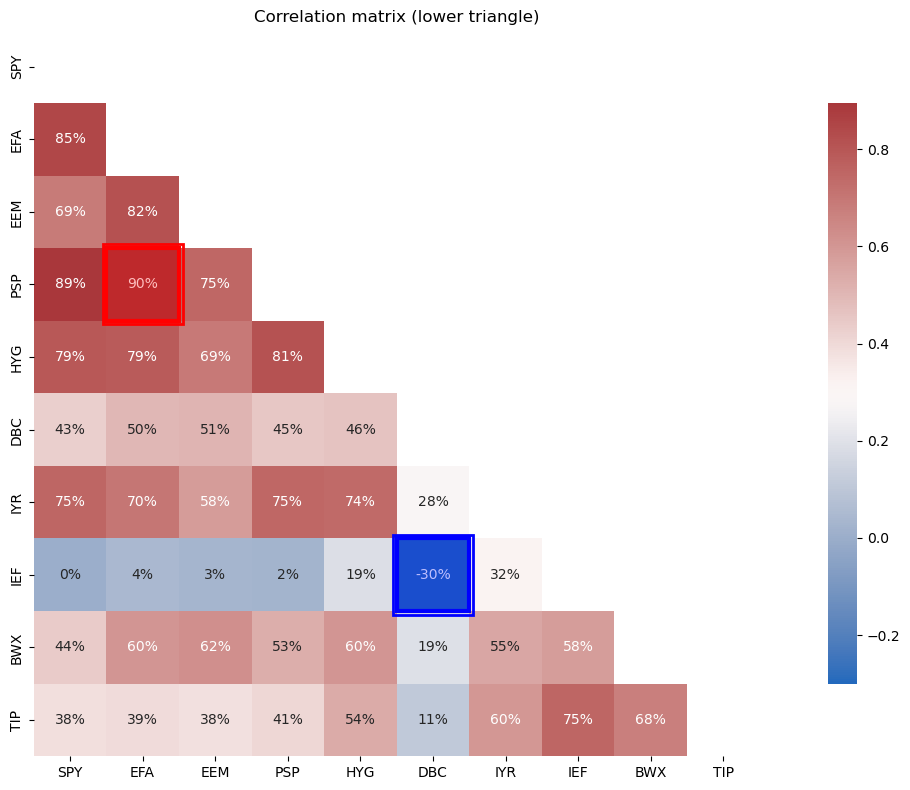

In [10]:
from cmds.plot_tools import plot_corr_matrix
plot_corr_matrix(retsx,triangle='lower',figsize=(14,8))
plt.show()

See the boxed values for the max and min correlations.

#### TIPS

TIPS have one of the highest Sharpe ratios--they have a low mean, but a very low volatility. 
* TIPS outperformed Domestic bonds, `IEF`.
* TIPS outperformed International bonds, `BWX`.

Notably, 
* TIPS have very low correlation to the other assets.
* TIPS provide a great deal of diversification to all assets except IEF, to which they still provide some diversification.

***

# Tangency Portfolio

### Technical Check

Note that the tangency portfolio may have extreme scaling, based on the nature of the data.
* It may be very high mean, high vol, and large (gross) weights.
* It may be on the lower portion of the mean-variance frontier, depending on the data set.

We can check for both of these things by checking whether the mean of the GMV portfolio is
* positive
* not near zero.

In [11]:
def sanity_check_tangency_from_returns(returns_df, extreme_factor: float = 3.0):
    """
    Compute on a returns DataFrame directly (e.g. excess returns).
    """
    cov     = returns_df.cov()
    mu      = returns_df.mean()

    invS    = np.linalg.inv(cov.values)
    one     = np.ones(mu.shape[0])

    A       = one @ invS @ one
    B       = one @ invS @ mu.values
    C       = mu.values @ invS @ mu.values

    mu_gmv  = B / A
    mu_tan  = C / B

    max_asset = np.max(np.abs(mu.values))
    
    return pd.DataFrame({
        'Value': [
            f"{mu_gmv:.2%}",
            f"{mu_tan:.2%}", 
            f"{max_asset:.2%}"
        ]
    }, index=[
        'GMV mean (unscaled)',
        'Tangency mean',
        'Max |asset mean|'
    ])

sanity_check_tangency_from_returns(retsx)


,Value
GMV mean (unscaled),0.22%
Tangency mean,1.07%
Max |asset mean|,1.07%


## The Tangency Weights

In [12]:
wts = pd.DataFrame(index=retsx.columns)
wts['tangency'] = tangency_weights(retsx)

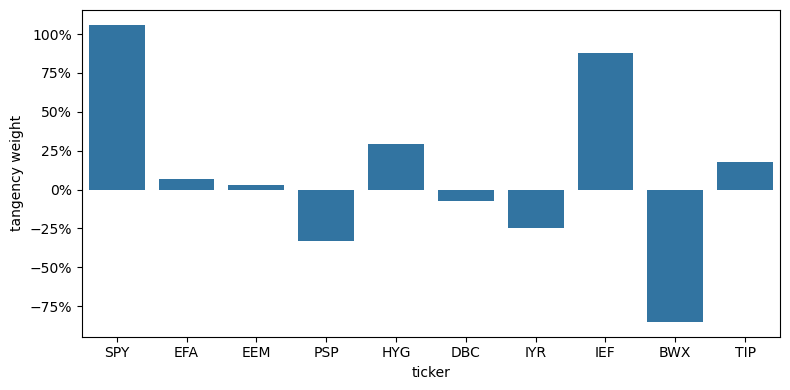

In [13]:
import matplotlib.ticker as mtick

fig, ax = plt.subplots(figsize=(8, 4))
sns.barplot(x=wts.index, y='tangency', data=wts, ax=ax)

# same formatter
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))
ax.set_ylabel('tangency weight')
ax.set_xlabel('ticker')
plt.tight_layout()
plt.show()

#### Tangency Weights are Not Proportional to Sharpe

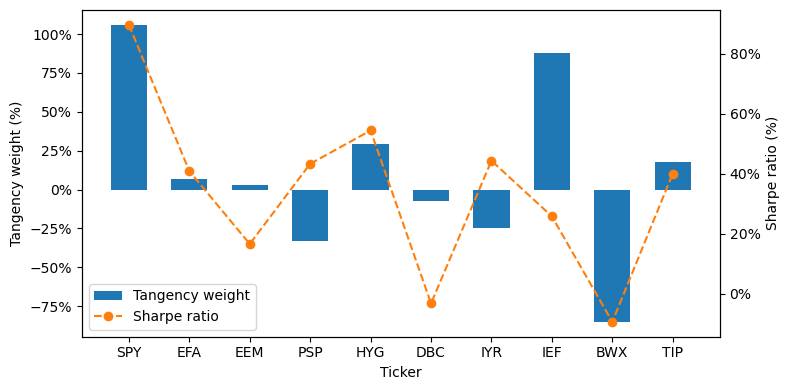

In [14]:
import matplotlib.ticker as mtick

labels = wts.index.tolist()        
x      = np.arange(len(labels))    
width  = 0.6                       

fig, ax1 = plt.subplots(figsize=(8,4))
ax2      = ax1.twinx()

bars1 = ax1.bar(
    x,
    wts['tangency'],
    width,
    label='Tangency weight',
    color='C0'
)

line2, = ax2.plot(
    x,
    mets.loc[labels, 'Sharpe'],
    marker='o',
    linestyle='--',
    label='Sharpe ratio',
    color='C1'
)

ax1.set_xticks(x)
ax1.set_xticklabels(labels)
ax1.set_xlabel('Ticker')

ax1.set_ylabel('Tangency weight (%)')
ax1.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))

ax2.set_ylabel('Sharpe ratio (%)')
ax2.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1 + h2, l1 + l2, loc='lower left')

plt.tight_layout()
plt.show()


#### The allocations are not even highly correlated to stand-alone Sharpe ratios!

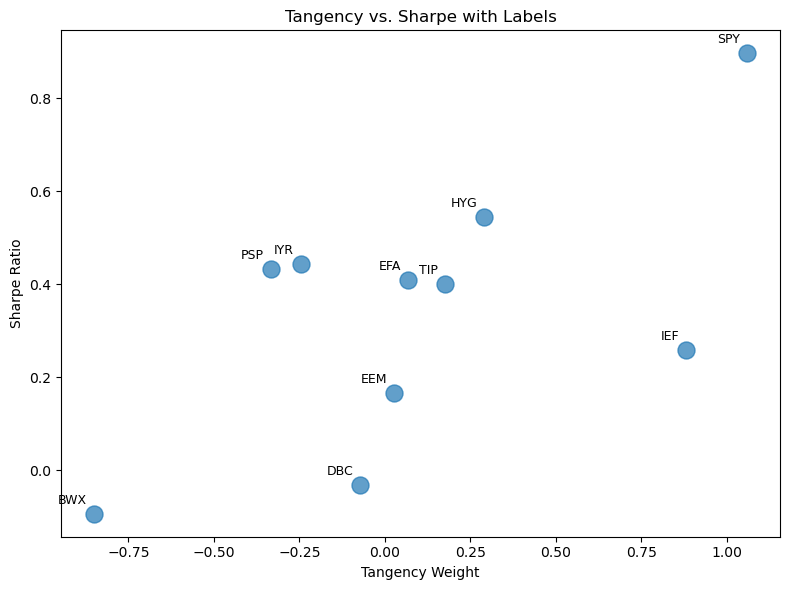

In [15]:
df_scatter = pd.DataFrame({
    'tangency': wts['tangency'],
    'Sharpe':   mets['Sharpe']
}).dropna()

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(
    df_scatter['tangency'],
    df_scatter['Sharpe'],
    s=150,
    alpha=0.7
)

for idx, (x, y) in df_scatter[['tangency','Sharpe']].iterrows():
    ax.annotate(
        str(idx),         # text
        xy=(x, y),        # point to label
        xytext=(-5, 5),   # offset: left 3, up 3 points
        textcoords='offset points',
        ha='right', va='bottom',
        fontsize=9
    )

ax.set_xlabel('Tangency Weight')
ax.set_ylabel('Sharpe Ratio')
ax.set_title('Tangency vs. Sharpe with Labels')
plt.tight_layout()
plt.show()


### Tangency Performance Compared to Stand-alone Assets

In [16]:
def highlight_by_index(index_names, color='aliceblue'):
    """
    Returns a function that, when applied row‐wise,
    will color the background for rows whose .name is in index_names.
    """
    def _highlight(row):
        return [
            f'background-color: {color}'
            if row.name in index_names else ''
            for _ in row
        ]
    return _highlight

In [17]:
retsx_tan = pd.DataFrame(retsx @ wts['tangency'],columns=['tangency'])
mets_tan = performanceMetrics(pd.concat([retsx,retsx_tan],axis=1),annualization=12)

In [18]:
sorted_df = mets_tan.sort_values('Sharpe',ascending=False)
to_highlight = ['tangency']

styled = (
    sorted_df
      .style
      .format('{:.0%}')
      .apply(highlight_by_index(to_highlight, color='teal'), axis=1)
)

styled

,Mean,Vol,Sharpe,Min,Max
tangency,13%,9%,147%,-5%,8%
SPY,13%,14%,90%,-13%,13%
HYG,4%,8%,54%,-10%,9%
IYR,7%,17%,44%,-20%,13%
PSP,9%,21%,43%,-28%,18%
EFA,6%,15%,41%,-14%,14%
TIP,2%,5%,40%,-7%,4%
IEF,2%,6%,26%,-5%,5%
EEM,3%,18%,17%,-18%,16%
DBC,-1%,17%,-3%,-18%,10%


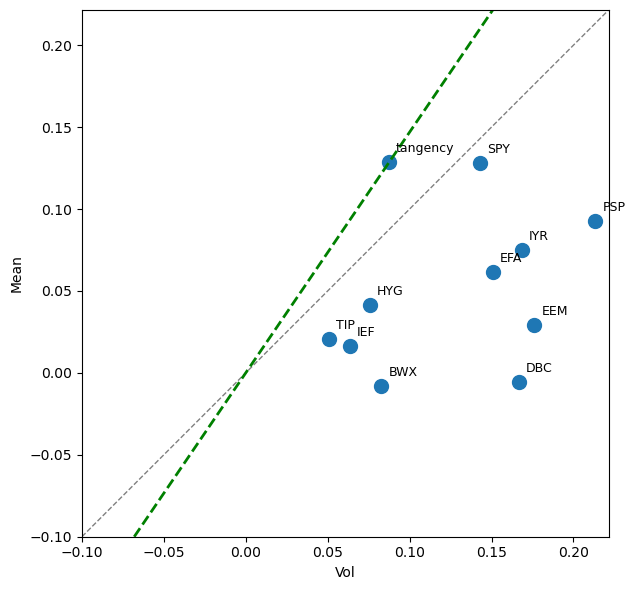

In [19]:
fig, ax = plt.subplots(figsize=(8, 6))

mets_tan.plot.scatter(x='Vol',y='Mean',ax=ax,s=100,xlim=(-.1,None),ylim=(-.1,None))

for idx, row in mets_tan.iterrows():
    ax.annotate(
        idx,                          # the label—here the DataFrame’s index
        (row['Vol'], row['Mean']),    # x,y coordinates
        textcoords="offset points",   # how to position the text
        xytext=(5,5),                 # offset in points (x,y)
        ha='left',                    # horizontal alignment
        va='bottom',                  # vertical alignment
        fontsize=9
    )

xlims = ax.get_xlim()
ylims = ax.get_ylim()
lims = [min(xlims[0], ylims[0]), max(xlims[1], ylims[1])]

# 3) plot the 45° line (y = x)
ax.plot(lims, lims, linestyle='--', color='gray', linewidth=1)
ax.set_xlim(lims)
ax.set_ylim(lims)



t = mets_tan.loc['tangency']
tx, ty = t['Vol'], t['Mean']

# Method A: infinite line using ax.axline (Matplotlib ≥3.3)
ax.axline((0, 0), (tx, ty),
          color='green', linestyle='--', linewidth=2,
          label='Zero–Tangency line')


# 4) tidy up
ax.set_aspect('equal', 'box')   # optional: force true square aspect
plt.tight_layout()
plt.show()

### The Mean-Variance Frontier

This chart will look better if tangency happens to have reasonable scaling, which depends on the data set for the problem.

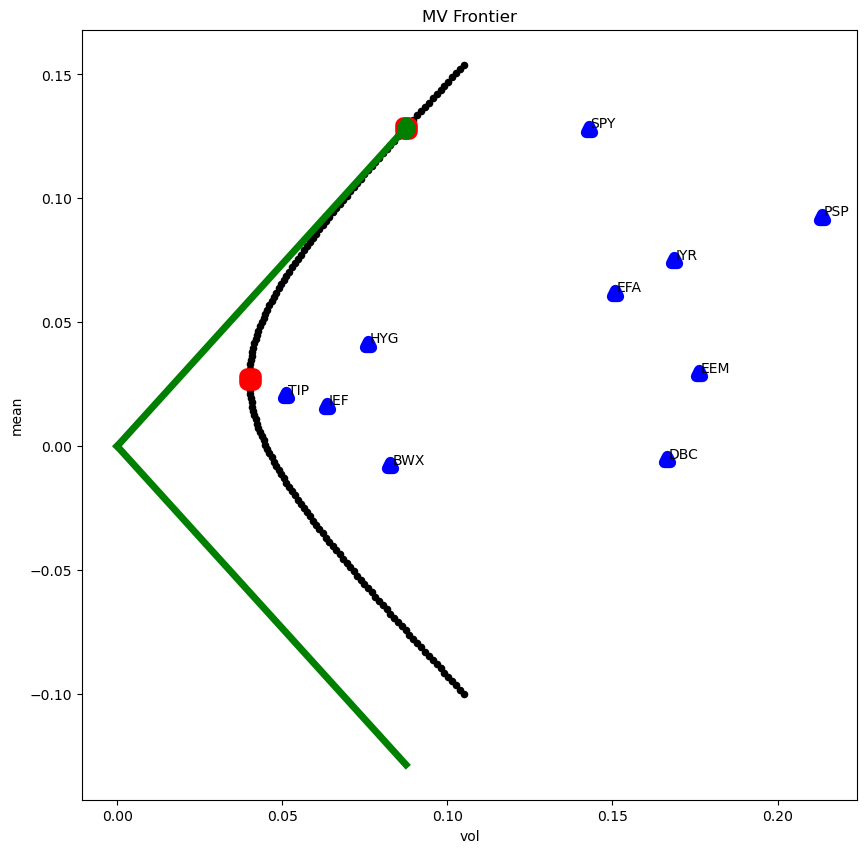

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# compute portfolios
omega_tan = tangency_weights(retsx)
vec_one_realized = retsx - retsx.mean() + 1
omega_gmv = tangency_weights(vec_one_realized)

omega = pd.concat([omega_tan, omega_gmv], axis=1)
omega.columns = ['tangency', 'gmv']

# build mv_frame without chained assignment
delta_grid = np.linspace(-1.25, 1.25, 150)
mv_frame = pd.DataFrame(columns=['mean','vol'], index=delta_grid)

for delta in delta_grid:
    omega_mv = delta * omega_tan + (1 - delta) * omega_gmv
    rets_p = retsx @ omega_mv
    mv_frame.loc[delta, 'mean'] = rets_p.mean().values[0] * 12
    mv_frame.loc[delta, 'vol']  = rets_p.std().values[0]  * np.sqrt(12)

# special returns
rets_special = pd.DataFrame(index=retsx.index)
rets_special['tan'] = retsx @ omega_tan.values
rets_special['gmv'] = retsx @ omega_gmv.values

# asset and special mv points
mv_assets = pd.concat([retsx.mean() * 12,
                       retsx.std()  * np.sqrt(12)], axis=1)
mv_assets.columns = ['mean','vol']

mv_special = pd.concat([rets_special.mean() * 12,
                        rets_special.std()  * np.sqrt(12)], axis=1)
mv_special.columns = ['mean','vol']

# plot frontier + assets + special points
ax = mv_frame.plot.scatter(x='vol', y='mean', c='k',
                           figsize=(10,10), title='MV Frontier')

mv_assets.plot.scatter(x='vol', y='mean', ax=ax,
                       c='b', marker='^', linewidth=8)

mv_special.plot.scatter(x='vol', y='mean', ax=ax,
                        c='r', marker='s', linewidth=12)

# label each asset safely
for name, row in mv_assets.iterrows():
    plt.text(x=row['vol'] + 0.0005,
             y=row['mean'] + 0.0005,
             s=name)

# tangency point in green diamond
rtan_temp = retsx @ tangency_weights(retsx)
pdtemp = pd.DataFrame([
    rtan_temp.mean().values * 12,
    rtan_temp.std().values * np.sqrt(12)
]).T
pdtemp.index = ['tangency']
pdtemp.columns = ['mean','vol']

pdtemp.plot.scatter(x='vol', y='mean', ax=ax,
                    c='g', marker='d', linewidth=10)

# green “line” from origin
xg = pdtemp.loc['tangency','vol']
yg = pdtemp.loc['tangency','mean']
plt.plot([0, xg], [0, yg],  color='green', linestyle='-', linewidth=5)
plt.plot([0, xg], [0, -yg], color='green', linestyle='-', linewidth=5)

plt.show()


***

# (In)Stability of the MV Frontier?

#### Weights if drop TIPS from investment set

In [21]:
wts_adj = wts[['tangency']].copy()

wts_adj['tangency ex tips'] = tangency_weights(retsx.drop(columns=['TIP']))
wts_adj.loc['TIP','tangency ex tips'] = 0

#### Suppose TIPS had a mean return 1% (annualized) higher than in the sample

* Would the weights change much?
* Would the MV frontier change much?

In [22]:
TIPS_ADJ = .01/12

retsx_adj = retsx.copy()
retsx_adj['TIP'] += TIPS_ADJ
wts_adj['tangency adj'] = tangency_weights(retsx_adj)

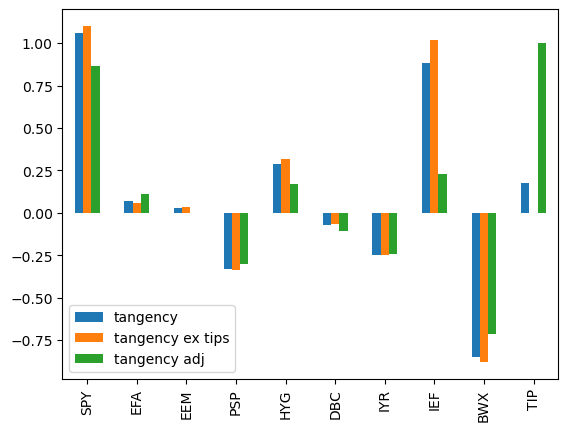

In [23]:
wts_adj.plot.bar();

In [24]:
retsx_tan_adj = pd.DataFrame(retsx_adj @ wts_adj['tangency adj'],columns=['tangency adj'])
mets_adj = performanceMetrics(retsx_adj @ wts_adj[['tangency adj']], annualization=12)
pd.concat([mets_tan.loc[['tangency']],mets_adj])

,Mean,Vol,Sharpe,Min,Max
tangency,0.1285,0.0875,1.4692,-0.0508,0.0823
tangency adj,0.1187,0.0768,1.5457,-0.0451,0.0838


#### Uncertainty in mean returns
Note that our adjustment to the mean return of TIPS is not so large relative to the standard error of TIPS.

In [25]:
tips_se = retsx['TIP'].std()/np.sqrt(retsx.shape[0])
print(f'Standard error of mean of TIPS is equal to {tips_se:0.2%}')
print(f'Proposed adjustment to mean of TIPS is {.01/12 : 0.2%}')

Standard error of mean of TIPS is equal to 0.11%
Proposed adjustment to mean of TIPS is  0.08%


### Conclusions on TIPS

* Dropping TIPS from the investment set barely impacts the weights or the resulting performance.
* Adjusting the mean of TIPS upward even just 1 standard error substantially impacts the allocations and moderately boosts the resulting performance.

Based on just a mean-variance analysis, it seems one could reasonably go either way with TIPS as an alternate asset class. In the argument to keep it separate, there is more diversification between TIPS and bonds than between SPY and many other equity buckets Harvard has. On the other hand, TIPS mostly impact the allocation to domestic bonds and might be seen as another asset in that bucket.

***

# MV Optimization

## Comparison Portfolios

Build the following portfolios:

#### Equally-weighted (EW)
Rescale the entire weighting vector to have target mean $\mutarg$. Thus, the $i$ element of the weight vector is,

$$\wEW_i = \frac{1}{n}$$

#### “Risk-parity” (RP)
Risk-parity is a term used in a variety of ways, but here we have in mind setting the weight of the portfolio to be proportional to the inverse of its full-sample variance estimate. Thus, the $i$ element of the weight vector is,

$$\wRP_i = \frac{1}{\sigma_i^2}$$

#### Regularized (REG)
Much like the Mean-Variance portfolio, set the weights proportional to 

$$\wREG \sim \widehat{\Sigma}^{-1}\mux$$

but this time, use a regularized covariance matrix,

$$\widehat{\Sigma} = \frac{\Sigma + \Sigma_D}{2}$$

where $\Sigma_D$ denotes a *diagonal* matrix of the security variances, with zeros in the off-diagonals.

Thus, $\widehat{\Sigma}$ is obtained from the usual covariance matrix, $\Sigma$, but shrinking all the covariances to half their estimated values. 

### Comparing

In order to compare all these allocation methods, (those above, along with the tangency portfolio obtained in the previous section,) rescale each weight vector, such that it has targeted mean return of $\mutarg$.

* Calculate the performance of each of these portfolios over the sample.
* Report their mean, volatility, and Sharpe ratio. 
* How do these compare across the four allocation methods?

## In-Sample Testing

Set target mean.

Be mindful that this is scaled to frequency of the time-series, not annual scaling.

In [26]:
TARG_MEAN = .01

In [27]:
wts['equal weights'] = 1/len(retsx.columns)
wts['risk parity'] = 1/retsx.var()
wts['regularized'] = tangency_weights(retsx,scale_cov=.5)

# rescale these to hit the target mean
wts *= TARG_MEAN / (retsx.mean()@wts)

In [28]:
performanceMetrics(retsx @ wts,annualization=12).style.format('{:.1%}')

,Mean,Vol,Sharpe,Min,Max
tangency,12.0%,8.2%,146.9%,-4.7%,7.7%
equal weights,12.0%,26.9%,44.6%,-32.5%,22.2%
risk parity,12.0%,26.4%,45.5%,-28.0%,19.3%
regularized,12.0%,10.6%,113.6%,-7.5%,11.0%


***

# Out-of-Sample Testing

## One-step Out-of-Sample (OOS) Performance
Let’s divide the sample to both compute a portfolio and then check its performance out of sample.
* Using only data through the end of `2022`, compute the weights built in Section 3.
* Rescale the weights, (using just the in-sample data,) to set each allocation to have the same mean return of $\mutarg$.
* Using those weights, calculate the portfolio’s Sharpe ratio within that sample.
* Again using those weights, (derived using data through `2022`,) calculate the portfolio’s OOS Sharpe ratio, which is based only on performance in `2023-2024`.

## Rolling OOS Performance

Iterate the Out-of-Sample performance every year, not just the final year. Namely,
* Start at the end of `2015`, and calculate the weights through that time. Rescale them using the mean returns through that time.
* Apply the weights to the returns in the upcoming year, (`2016`.)
* Step forward a year in time, and recompute.
* Continue until again calculating the weights through `2023` and applying them to the returns in `2024`.

In [29]:
SPLIT0 = '2023'
SPLIT1 = '2024'

retsxIS = retsx.loc[:SPLIT0]
retsxOOS = retsx.loc[SPLIT1:]

retsxIS_adj = retsxIS.copy()
retsxIS_adj['TIP'] += TIPS_ADJ

wtsIS = pd.DataFrame(index=wts.index, columns=wts.columns, dtype=float)
wtsIS['tangency'] = tangency_weights(retsxIS)

tangency_ex_tips = tangency_weights(retsxIS.drop(columns=['TIP'])).values[:, 0]
wtsIS.loc[wtsIS.index[:-1], 'tangency ex tips'] = tangency_ex_tips
wtsIS.loc['TIP','tangency ex tips'] = 0

wtsIS['tan tips adj'] = tangency_weights(retsxIS_adj)
wtsIS['equal weights'] = 1/len(retsxIS.columns)
wtsIS['risk parity'] = 1/retsxIS.var()
wtsIS['regularized'] = tangency_weights(retsxIS,scale_cov=.5)

# rescale these to hit the target mean
wtsIS *= TARG_MEAN / (retsxIS.mean()@wtsIS)

In [30]:
import pandas as pd
from IPython.display import display

# 1) Pick a more contrasting highlight
oos_color = '#ffd54f'   # amber — works in both light & dark modes
text_color = 'black'    # force text to black for legibility

# 2) Data‐cell highlighter: background + text color
def highlight_oos(col):
    if col.name[0] == 'out-of-sample':
        return [f'background-color: {oos_color}; color: {text_color}'] * len(col)
    else:
        return [''] * len(col)

# 3) Build your two‐level DataFrame
perf_IS_OOS = pd.concat(
    [
        performanceMetrics(retsxIS @ wtsIS, annualization=12),
        performanceMetrics(retsxOOS @ wtsIS, annualization=12)
    ],
    keys=['in-sample', 'out-of-sample'],
    axis=1
)

# 4) Find the positions of the out‐of‐sample columns in the flat index
oos_positions = [
    i for i, (lvl0, lvl1) in enumerate(perf_IS_OOS.columns)
    if lvl0 == 'out-of-sample'
]

# 5) Build header styles (level0 & level1) with matching bg + text color
header_styles = []
for pos in oos_positions:
    for level in (0, 1):
        header_styles.append({
            'selector': f'th.col_heading.level{level}.col{pos}',
            'props': [
                ('background-color', oos_color),
                ('color', text_color),
            ]
        })

# 6) Put it all together
styled = (
    perf_IS_OOS
      .style
      .format('{:.1%}')
      .apply(highlight_oos, axis=0)                  # shade data cells
      .set_table_styles(header_styles, overwrite=False)  # shade headers
)

# 7) Display in your notebook
display(styled)


***

# Addendum: No Risk-Free Rate

### Tangency with and without a risk-free rate

Consider how similar are the tangency to 0 (in total returns) and tangency to risk-free (excess returns)?

In [31]:
rets_special_riskfree = rets_special.copy()
mv_special_riskfree = mv_special.copy()

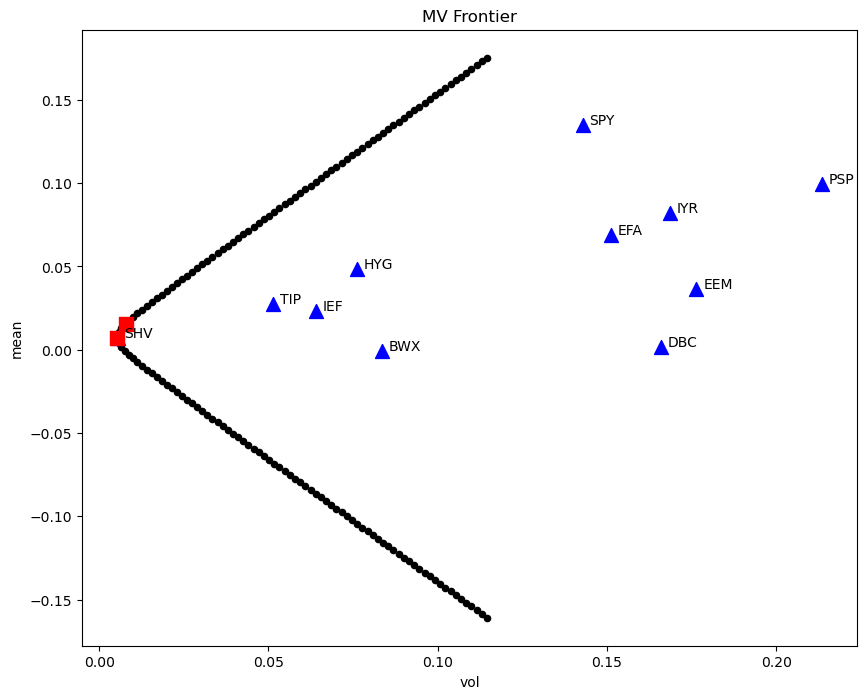

In [32]:
# compute weights
omega_tan = tangency_weights(rets)
rets_adj = rets.sub(rets.mean(), axis='columns').add(1)
omega_gmv = tangency_weights(rets_adj)

omega = pd.concat([omega_tan, omega_gmv], axis=1)
omega.columns = ['tangency', 'gmv']

# build the MV frontier 
delta_grid = np.linspace(-20, 20, 150)
mv_frame = pd.DataFrame(index=delta_grid, columns=['mean', 'vol'], dtype=float)

for delta in delta_grid:
    ω = delta * omega['tangency'] + (1 - delta) * omega['gmv']
    rets_p = rets.dot(ω)                
    μ = rets_p.mean() * 12
    σ = rets_p.std() * np.sqrt(12)
    mv_frame.loc[delta, 'mean'] = μ     
    mv_frame.loc[delta, 'vol']  = σ

# special portfolios
rets_special = pd.DataFrame({
    'tan': rets.dot(omega['tangency']),
    'gmv': rets.dot(omega['gmv'])
}, index=rets.index)

mv_assets = pd.DataFrame({
    'mean': rets.mean() * 12,
    'vol':  rets.std() * np.sqrt(12)
})

mv_special = pd.DataFrame({
    'mean': rets_special.mean() * 12,
    'vol':  rets_special.std() * np.sqrt(12)
})

# plot
ax = mv_frame.plot.scatter(
    x='vol', y='mean', c='k', figsize=(10,8), title='MV Frontier'
)
mv_assets.plot.scatter(
    x='vol', y='mean', ax=ax, c='b', marker='^', s=100
)
mv_special.plot.scatter(
    x='vol', y='mean', ax=ax, c='r', marker='s', s=100
)

# label using .iterrows()
for name, row in mv_assets.iterrows():
    plt.text(
        x = row['vol']  + 0.002,
        y = row['mean'] + 0.0005,
        s = str(name)
    )

plt.show()

The tangency portfolios are very similar, whether including a risk-free rate or not.
* tangency (to 0)
* tangency (to risk-free rate)

In [33]:
temp = pd.concat([mv_special_riskfree,mv_special],keys=['excess','total'],axis=1).loc['tan',:].to_frame()['tan'].unstack(level=1)
temp.style.format('{:.1%}').set_caption('Tangency portfolio: excess vs total returns')

,mean,vol
excess,12.9%,8.7%
total,1.6%,0.8%


In [34]:
rho = pd.concat([rets_special,rets_special_riskfree],axis=1).corr()
tab = pd.DataFrame([rho.loc['tan','tan'].iloc[0,1]], index=['tan'], columns=['rho'])
tab.style.format('{:.1%}')

,rho
tan,73.3%


***